In [1]:
# Importing libraries
import pandas as pd
import numpy as np

# Importing data (dataset contains the list of the metabolites and their estimates in the outcomes being tested)
# Column format: Metabolite, Outcome 1 (OR), Outcome 2 (OR),... Outcome n (OR)
data1 = pd.read_csv('<filename>.csv')

# Hierarchical Clustering

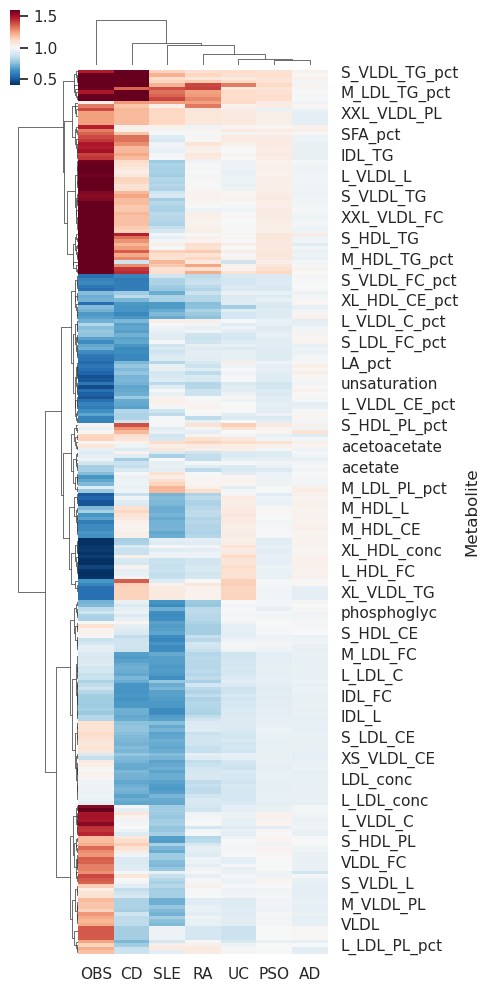

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True, font_scale = 1) 

# Creating the clustermap
data2 = data1.set_index('Metabolite') # Set the metabolite name as index

# Uncomment the following for making an additional colorcode for the metabolite groups
#groups = data2['Group']
#lut = dict(zip(groups.unique(),
#               ['#D84315',
#                '#FBC02D',
#                '#689F38',
#                '#00796B',
#                '#0288D1',
#                '#303F9F',
#                '#C2185B',
#                '#EFEBE9',
#                '#C2185B',
#                '#8BC34A',
#                '#BDBDBD'])) 
#row_colors = groups.map(lut) 

clust_plot = sns.clustermap(data2.iloc[:,1:],
                            figsize =(5, 10),
                            colors_ratio=0.1, 
                            #row_colors = row_colors, # Uncomment to show the additional color code
                            dendrogram_ratio = (0.2, 0.05),
                            method = "ward",
                            cmap = "RdBu_r",
                            vmin = 0.4,
                            vmax = 1.6,
                            cbar_pos=(0.025,0.915,0.02,0.075)
                           )
clust_plot.ax_heatmap.tick_params(right=False, bottom=False)

clust_plot.savefig('<filename>.pdf') 

# Calculate FDR (Benjamini-Hochberg Correction)

In [34]:
from numpy import array, empty

def correct_pvalues_for_multiple_testing(pvalues, correction_type = 'Benjamini-Hochberg'):                
    from numpy import array, empty                                                                        
    pvalues = array(pvalues) 
    n = 249                                                                           
    new_pvalues = empty(n)
    if correction_type == 'Bonferroni':                                                                   
        new_pvalues = n * pvalues
    elif correction_type == 'Bonferroni-Holm':                                                            
        values = [ (pvalue, i) for i, pvalue in enumerate(pvalues) ]                                      
        values.sort()
        for rank, vals in enumerate(values):                                                              
            pvalue, i = vals
            new_pvalues[i] = (n-rank) * pvalue                                                            
    elif correction_type == 'Benjamini-Hochberg':                                                         
        values = [ (pvalue, i) for i, pvalue in enumerate(pvalues) ]                                      
        values.sort()
        values.reverse()                                                                                  
        new_values = []
        for i, vals in enumerate(values):                                                                 
            rank = n - i
            pvalue, index = vals                                                                          
            new_values.append((n/rank) * pvalue)                                                          
        for i in range(0, int(n)-1):  
            if new_values[i] < new_values[i+1]:                                                           
                new_values[i+1] = new_values[i]                                                           
        for i, vals in enumerate(values):
            pvalue, index = vals
            new_pvalues[index] = new_values[i]                                                                                                                  
    return new_pvalues

In [39]:
imids = ['pso', 'ad', 'ra', 'sle', 'cd', 'uc']

for i in range(len(imids)):
    df = pd.read_excel('[' + imids[i] + '] summary statistics.xlsx')
    pvalues = df['P-Value'].to_list()
    new_pvalues = correct_pvalues_for_multiple_testing(pvalues, correction_type = 'Benjamini-Hochberg')
    df['FDR'] = new_pvalues
    df.to_excel('[' + imids[i] + '] FDR.xlsx', index=False)

# Upset Plot

In [2]:
# Importing data (dataset contains the list of the significant metabolites for each outcome)
# Column format: Outcome 1 (Metabolites), Outcome 2 (Metabolites), ... Outcome n (Metabolites)
data3 = pd.read_excel('<filename>.xlsx')

,Metabolites,PSO,AD,RA,SLE,CD,UC
0,LDL_FC,LDL_FC,NaN,LDL_FC,LDL_FC,LDL_FC,LDL_FC
1,albumin,albumin,NaN,albumin,albumin,albumin,albumin
2,L_LDL_FC,L_LDL_FC,NaN,L_LDL_FC,L_LDL_FC,L_LDL_FC,L_LDL_FC
3,S_LDL_FC,S_LDL_FC,NaN,S_LDL_FC,S_LDL_FC,S_LDL_FC,S_LDL_FC
4,IDL_C_pct,IDL_C_pct,NaN,IDL_C_pct,IDL_C_pct,IDL_C_pct,IDL_C_pct


In [12]:
# Convert data to upset compatible format
from upsetplot import from_contents

pso = data['pso'].dropna().unique().tolist()
ad = data['ad'].dropna().unique().tolist()
ra = data['ra'].dropna().unique().tolist()
sle = data['sle'].dropna().unique().tolist()
cd = data['cd'].dropna().unique().tolist()
uc = data['uc'].dropna().unique().tolist()

imids = from_contents({'PSO': pso, 
                       'AD' : ad, 
                       'RA' : ra, 
                       'SLE' : sle, 
                       'CD' : cd, 
                       'UC' : uc}) 

id
PSO   AD    RA    SLE   CD    UC                  
True  False True  True  True  True          LDL_FC
                              True         albumin
                              True        L_LDL_FC
                              True        S_LDL_FC
                              True       IDL_C_pct
...                                            ...
False False False False True  False  XL_HDL_TG_pct
                              False   L_HDL_FC_pct
                              False   L_HDL_TG_pct
                        False True   XL_HDL_PL_pct
                              True   XL_HDL_FC_pct

[202 rows x 1 columns]

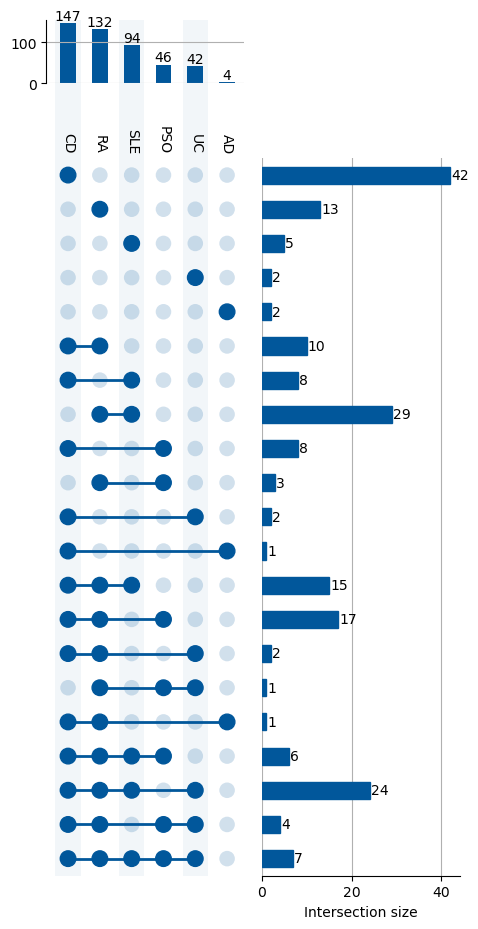

In [17]:
# Create an upset plot
from upsetplot import UpSet
import matplotlib.pyplot as plt

ax_dict = UpSet(imids, 
                subset_size='count', 
                show_counts=True, 
                orientation='vertical',
                facecolor='#01579B'
               ).plot()

plt.savefig('<filename>.pdf')